In [265]:
%%bash
pip install tsfresh
pip install ipywidgets
jupyter nbextension enable --py --sys-prefix widgetsnbextension

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [234]:
%%bash
jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [266]:
import os
import inspect
import sys
import pandas as pd
import charts
import numpy as np
import pylab as pl
from scipy import spatial
from scipy.spatial import distance
from sklearn.cluster import MeanShift
import time
import math
from opengrid.library import houseprint

In [267]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
34 Sites created
34 Devices created
97 sensors created
Houseprint parsing complete


In [268]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

In [269]:
gas = hp.find_sensor('212ce724e124fbde0fb649396375d099')
#gas = hp.find_sensor('a6028457292f1866b468b63adcc82ee3') 2
#gas = hp.find_sensor('a6028457292f1866b468b63adcc82ee3')
print gas


    Fluksosensor
    Key: 212ce724e124fbde0fb649396375d099
    Type: gas
    


In [239]:
head = pd.Timestamp('20151110')
tail = pd.Timestamp('20151118')
originalGraph = gas.get_data(head=head, tail=tail, diff=True, resample='min', unit='kW')
originalGraphDf=pd.DataFrame(originalGraph)
originalGraphDfDropNa = originalGraphDf.dropna()
charts.plot(originalGraph, stock=True, show='inline')

Using tmpo database from /data/.tmpo/tmpo.sqlite3


In [240]:
dfCompare=dfRepeatedValues.ix[pd.Timestamp('2015-11-13 16:25:00+00:00'):pd.Timestamp('2015-11-13 17:16:00+00:00')]
#dfCompare2=dfRepeatedValues.ix[pd.Timestamp('2015-11-14 15:25:00+00:00'):pd.Timestamp('2015-11-14 16:45:00+00:00')]
dfCompareOriginal=originalGraphDf.ix[pd.Timestamp('2015-11-13 16:25:00+00:00'):pd.Timestamp('2015-11-13 17:16:00+00:00')]
dfCompareOriginal2=originalGraphDf.ix[pd.Timestamp('2015-11-14 15:25:00+00:00'):pd.Timestamp('2015-11-14 16:45:00+00:00')]
dfCompareOriginal3=originalGraphDf.ix[pd.Timestamp('2015-11-23 08:20:00+00:00'):pd.Timestamp('2015-11-23 13:45:00+00:00')]
dfCompareOriginal4=originalGraphDf.ix[pd.Timestamp('2015-11-18 04:47:00+00:00'):pd.Timestamp('2015-11-18 05:29:00+00:00')]
dfCompareOriginal5=originalGraphDf.ix[pd.Timestamp('2015-11-17 21:03:00+00:00'):pd.Timestamp('2015-11-17 21:05:00+00:00')]
dfCompareOriginal6=originalGraphDf.ix[pd.Timestamp('2015-11-11 20:20:00+00:00'):pd.Timestamp('2015-11-11 20:37:00+00:00')]
dfCompareOriginal7=originalGraphDf.ix[pd.Timestamp('2015-11-17 18:21:00+00:00'):pd.Timestamp('2015-11-17 18:34:00+00:00')]

<h3> Different compare methods </h3>

In [241]:
def diffArrays(array1,array2):
    array=[]
    if array1.index.size==array2.index.size:
        for i in range(0,array1.index.size):
            array.append(array2.iloc[i]-array1.iloc[i])
    df=pd.DataFrame(array)
    return df

<h4> Manhattan Distance: the method we will use </h4>

In [242]:
def manhattanDistance2(s1,s2):
    dist = distance.cityblock(s1,s2)
#     maxValues=np.maximum(s1,s2)
#     maxValues=np.max(maxValues)
#     manhattan=dist/maxValues
    return dist

In [243]:
def euclideanDistance(s1,s2):
    #Verwacht een numpy array
    dist = np.linalg.norm(s1-s2)
    return dist

In [244]:
def cosineSimilarity(s1,s2):
    similarity = 1 - spatial.distance.cosine(s1, s2)
    return similarity

In [245]:
def mahalanobisDistance(s1,s2):
    similarity = 1 - distance.mahalanobis(s1,s2)
    return similarity

In [246]:
def chebychev(s1,s2):
    dist =  distance.chebyshev(s1,s2)
    return dist

In [247]:
def manhattanDistance(s1,s2):
    difference=diffArrays(s1,s2)
    absDifference=abs(difference)
    sumOfValues=np.sum(absDifference)
    maxValues=np.maximum(s1,s2)
    maxValues=np.max(maxValues)
    manhattan=sumOfValues/maxValues
    return manhattan

In [248]:
def hammingDistance(s1, s2):
    """Return the Hamming distance between equal-length sequences"""
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

In [249]:
def paa_transform(timeSeries, n_pieces):
    splitted = np.array_split(timeSeries, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [250]:
def znormalization(ts):
    #Pakt mean, std van kolom.
    meanCalc = ts.mean(axis = 0)
    stdCalc = ts.std(axis = 0)
    return (ts - meanCalc) / stdCalc

In [251]:
def sax_transform(ts, n_pieces, alphabet):
    """
    ts: columns of which are time serieses represented by np.array
    n_pieces: number of segments in paa transformation
    alphabet: the letters to be translated to, e.g. "abcd", "ab"
    return np.array of ts's sax transformation
    Steps:
    1. znormalize
    2. paa
    3. find norm distribution breakpoints by scipy.stats
    4. convert paa transformation into strings
    """
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    return np.apply_along_axis(translate, 0, paa_ts)

In [252]:
def makeArray(array1):
    arrayValues=[]    
    for i in range(0, array1.size-1):
        if(i<array1.size):
             arrayValues.append(ord(array1.iloc[i])-97)
    df=pd.DataFrame(arrayValues)
    return df

In [253]:

def makeDiffArray(array): #Excepts a letter array
    arrayValues=[]    
    for i in range(0, array.size-1):
        if(i<array.size):
             arrayValues.append(ord(array.iloc[i+1])-ord(array.iloc[i]))
    df=pd.DataFrame(arrayValues)
    return df          


In [254]:
def differenceNumbers(array): #Expects array of numbers @
    arrayValues=[]
    for i in range(0, array.index.size):
        arrayValues.append(np.diff(array.iloc[i], axis=-1))
    df=pd.DataFrame(arrayValues)
    return df

In [255]:
def diffArrays(array1,array2):
    array=[]
    if array1.index.size==array2.index.size:
        for i in range(0,array1.index.size):
            array.append(array2.iloc[i]-array1.iloc[i])
    df=pd.DataFrame(array)
    return df

In [256]:
zScores=znormalization(originalGraph)

<h3> Visualisation of the different graphs (PAA, SAX, original graph, zscores) </h3>

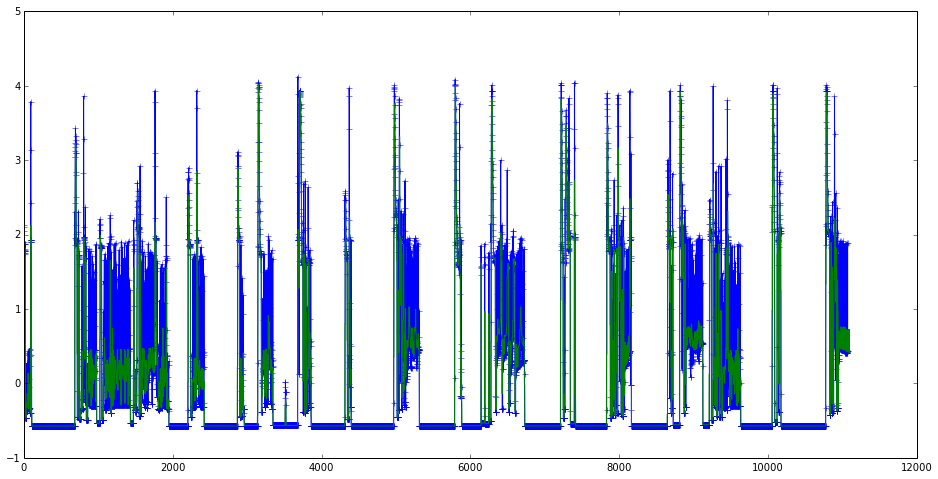

In [221]:
paaTransform = paa_transform(zScores,1850)
paaTransfo = np.repeat(paaTransform,6, axis = 0)
pl.figure()
pl.plot(zScores, '-+')
pl.plot(paaTransfo)
pl.legend(loc = "upper left")

In [257]:
# originalGraphDf=pd.DataFrame(originalGraph)
# paaTransfoDf=pd.DataFrame(paaTransfo)
# paaTransfoDf=paaTransfoDf.iloc[:paaTransfoDf.size-27]
# paaTransfoDf.index=originalGraphDf.index
# graph = pd.concat([paaTransfoDf,zScores],axis=1).dropna()
# charts.plot(graph,stock=True,show='inline')


<h3> Change numbers to letters </h3>

In [223]:
saxTransformation=sax_transform(originalGraph, 1850, "abcdefghijklmn")

In [258]:
# '''
# Werkwijze:
# Dataframes gebruiken!
# -sax transfo
# -lettersq->nummers (makeArray())
# -np.repeat (plateau's)
# -plot(paa_transform+repeater,^)
# '''

# letters=pd.DataFrame(saxTransformation)
# letters.columns=['col1']
# lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

# repeatedValues=np.repeat(lettersToNumSax.as_matrix(),6) #expects an array

# dfRepeatedValues=pd.DataFrame(repeatedValues)

# dfRepeatedValues=dfRepeatedValues.iloc[:dfRepeatedValues.size-21]
# paaTransfoDf.index=dfRepeatedValues.index

# concatinatePaaAndSax=pd.concat([znormalization(dfRepeatedValues),paaTransfoDf],axis=1)
# concatinatePaaAndSax.columns=['col1','col2']

# charts.plot(concatinatePaaAndSax,stock=True,show='inline')


In [259]:
# dfRepeatedValues.index=zScores.index
# saxVsOriginalGraph=pd.concat([(dfRepeatedValues), znormalization(originalGraph)],axis=1).dropna()
# charts.plot(saxVsOriginalGraph, stock=True, show='inline')

In [260]:
# saxVsOriginalGraph2=pd.concat([(dfRepeatedValues), (originalGraph)],axis=1).dropna()
# charts.plot(saxVsOriginalGraph2, stock=True, show='inline')

# Storing comparing arrays used in the methods below

In [31]:
# dfCompare=dfRepeatedValues.ix[pd.Timestamp('2015-11-13 16:25:00+00:00'):pd.Timestamp('2015-11-13 17:16:00+00:00')]
# dfCompare2=dfRepeatedValues.ix[pd.Timestamp('2015-11-14 15:25:00+00:00'):pd.Timestamp('2015-11-14 16:45:00+00:00')]
dfCompareOriginal=originalGraphDf.ix[pd.Timestamp('2015-11-13 16:25:00+00:00'):pd.Timestamp('2015-11-13 17:16:00+00:00')]
dfCompareOriginal2=originalGraphDf.ix[pd.Timestamp('2015-11-14 15:25:00+00:00'):pd.Timestamp('2015-11-14 16:45:00+00:00')]

# New method with timestamp correction and automatic graph creation

In [168]:
 def calculate_lowest_values(dfWithValues, arrayToCompare, amountOfSaves, amountOfValues):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    valuesList=[]

    #Create list with results of the methods
    resultList=[]
    dfResult=pd.DataFrame(resultList)
    compareToArray=np.array(arrayToCompare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    loopIndex=0 #Loops through the resultslist, as long as its size
    currentSaves=0 #Current amount of variables saved
    arrayWithValues=np.array(dfWithValues)
    startingTimeStamp=dfWithValues.index[0]#Todo with speed
    stopTimeStamp=dfWithValues.index[arrayToCompare.size-1]
    
    
    #LOOPING THROUGH LIST
    while i < arrayToCompare.size+j: #i is dependent on j, i updates as j updates.
        valuesList.append(([arrayWithValues[i][0]]))
        i=i+1
        if(i==(arrayToCompare.size+j)) and(j<amountOfValues) and (i<=(dfWithValues.size-arrayToCompare.size)): #amountOfValuesToBeConsidered.
            #j = the minute at this moment. i = starting from the current minute, adding the size of the array to compare.
            #Stops running when the limit of values to be considered is reached, being the size the original array.
            valuesToArray=np.array(valuesList)
            if(j==0) or (manhattanDistance2(compareToArray,valuesToArray)!=resultList[len(resultList)-1][0]):
                #Create list with values. Save them in "resultList". Euclidean score, startTimestamp, stopTimestamp
                resultList.append([manhattanDistance2(compareToArray,valuesToArray), startingTimeStamp,stopTimeStamp]) 
            j=j+1
            startingTimeStamp=dfWithValues.index[j] #startingTimeStamp: current minute considered
            stopTimeStamp=dfWithValues.index[i] #stopTimeStamp: current minute considered + size of array to compare.
            i=j
            valuesList=[]
    
    
    #SAVING ONLY RELEVANT VALUES       
    #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
    while loopIndex < len(resultList):
        if(currentSaves<amountOfSaves): #First save x amount of variables into the array
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex][0], resultList[loopIndex][1], resultList[loopIndex][2]]
            dfResult=dfResult.append(pd.DataFrame([[value, startTimeStamp,stopTimeStamp]], index=[currentSaves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            currentSaves=currentSaves+1
            #print "index:",loopIndex
        #Only adding values if value is lower than the 2 neighbours
        elif(resultList[loopIndex-1][0] < resultList[loopIndex-2][0]) and (resultList[loopIndex-1][0] < resultList[loopIndex][0]) and resultList[loopIndex-1][0] < dfResult.max()['Manhattan']:
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            thresholdValue=arrayToCompare.size/10
            listWithValues=[]
            maxValue=0
            i=0 
            
            
            #!!!Timestamps are important. If timestamp is within the range of another timestamp already present,
            #they will overwrite eachother instead of adding a new unique value
            while i < dfResult.index.size:
                if(startTimeStamp >= dfResult['startTimeStamp'][i]) and (startTimeStamp <= dfResult['stopTimeStamp'][i]-pd.Timedelta(minutes=thresholdValue)):
                    if(dfResult.loc[i][0] > maxValue) and (dfResult.loc[i][0]!=0): #Store the maximum value, of the range between start and stoptimestamp.
                        maxValue=dfResult.loc[i][0]
                        ts=dfResult.loc[i][1]
                    elif(dfResult.loc[i][0]==0):
                         #print "THE PERFECT MATCH IS FOUND WITH TIMESTAMP:", ts," AND VALUE: ", dfResult.loc[i][0]
                        maxValue=1
                i=i+1
            if(maxValue==0): #Means that start and stop timestamp are outside of the boundaries
                dfResult.loc[dfResult['Manhattan'].idxmax()]=[value,startTimeStamp, stopTimeStamp]
            elif(value < maxValue): #Check if the current value is smaller than the Maximum value encountered
                    dfResult.loc[dfResult['Manhattan']== maxValue] = [value, startTimeStamp, stopTimeStamp]
        loopIndex=loopIndex+1
    dfResult=dfResult.sort_values(['Manhattan'])
    return dfResult
#     return charts.plot(listWithGraphs, stock=True, show='inline')
        

In [169]:
def create_graph_from(df):
    listWithGraphs=[]
    listWithGraphs=pd.DataFrame(listWithGraphs)
    for i in range (0, df.index.size):
        listWithGraphs=listWithGraphs.append(originalGraphDfDropNa.ix[pd.Timestamp(df['startTimeStamp'][i]):pd.Timestamp(df['stopTimeStamp'][i])])
    return charts.plot(listWithGraphs, stock=True, show='inline')

<h2> Calculating threshold value </h2>

In [170]:
best_values_df=calculate_lowest_values(originalGraphDfDropNa, dfCompareOriginal, 10, originalGraphDfDropNa.size)

In [171]:
best_values_df

,Manhattan,startTimeStamp,stopTimeStamp
8,0.000000,2015-11-13 16:25:00+00:00,2015-11-13 17:16:00+00:00
4,51.040555,2015-11-14 06:04:00+00:00,2015-11-14 06:55:00+00:00
9,52.612096,2015-11-17 17:11:00+00:00,2015-11-17 18:02:00+00:00
1,55.597896,2015-11-14 14:13:00+00:00,2015-11-14 15:04:00+00:00
3,60.481144,2015-11-19 14:37:00+00:00,2015-11-19 15:28:00+00:00
2,64.541744,2015-11-12 09:57:00+00:00,2015-11-12 10:48:00+00:00
6,65.961733,2015-11-23 14:44:00+00:00,2015-11-23 15:35:00+00:00
0,70.112119,2015-11-15 16:07:00+00:00,2015-11-15 16:58:00+00:00
5,71.200876,2015-11-16 08:28:00+00:00,2015-11-16 09:19:00+00:00
7,71.506689,2015-11-20 05:28:00+00:00,2015-11-20 06:19:00+00:00


In [261]:
# create_graph_from(best_values_df)

In [1068]:
df100 = [1]
df100=pd.DataFrame(df100,index=[0])
for i in range (1,100):
    df100=df100.append(pd.DataFrame([i], index=[i]))
best_values_df.index=df100.index

<h2> Clustering </h2>

<h3> Storing mean/max/median </h3>

In [1069]:
maxValues=[]
dfMaxValues=pd.DataFrame(maxValues)
meanValues=[]
medianValues=[]
for i in range (0,100):
        maxValues.append(originalGraphDfDropNa.ix[pd.Timestamp(best_values_df['startTimeStamp'].iloc[i]):pd.Timestamp(best_values_df['stopTimeStamp'].iloc[i])].max())
        meanValues.append(originalGraphDfDropNa.ix[pd.Timestamp(best_values_df['startTimeStamp'].iloc[i]):pd.Timestamp(best_values_df['stopTimeStamp'].iloc[i])].mean())
        medianValues.append(originalGraphDfDropNa.ix[pd.Timestamp(best_values_df['startTimeStamp'].iloc[i]):pd.Timestamp(best_values_df['stopTimeStamp'].iloc[i])].median())

<h3> Normalizing the results and storing in df </h3>

In [1070]:
max_values=pd.DataFrame(maxValues)
mean_values=pd.DataFrame(meanValues)
median_values=pd.DataFrame(medianValues)
norm_max_values= max_values/max_values.max()
norm_mean_values=mean_values/mean_values.max()
norm_median_values=median_values/median_values.max()
norm_manhattan=best_values_df['Manhattan']/best_values_df['Manhattan'].max()

In [1071]:
best_values_df_concat = pd.concat([bestValuesDf,max_values, mean_values, median_values,norm_manhattan*2,norm_max_values,norm_mean_values,norm_median_values],axis=1)
best_values_df_concat.columns=['Manhattan','startTimeStamp','stopTimeStamp','Max', 'Mean', 'Median', 'normManhattan','normMax', 'normMean','normMedian']

<h3> Clustering operation </h3>

In [1084]:
df_result = pd.DataFrame(data=[best_values_df_concat['normManhattan'].as_matrix(),best_values_df_concat['normManhattan'].as_matrix()]).transpose()
result=df_result.as_matrix()

In [1085]:
ms = MeanShift()
ms.fit(result)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_cluster = len(np.unique(labels))
colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']

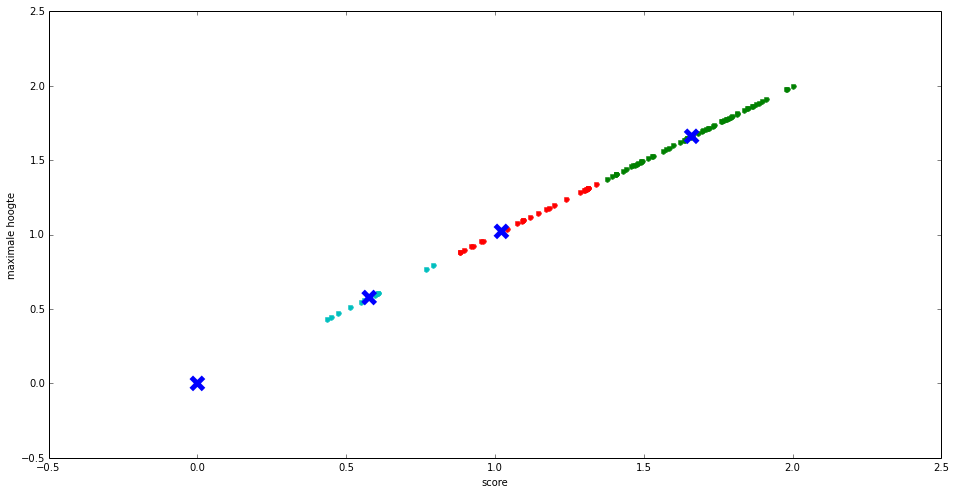

In [1086]:
for i in range(len(result)):
    plt.plot(result[i][0], result[i][1], colors[labels[i]], markersize = 10)

plt.scatter(cluster_centers[:,0],cluster_centers[:,1], marker = "x", s = 150, linewidths = 5, zorder = 10)
plt.xlabel('score')
plt.ylabel('maximale hoogte')
plt.show()

<h3>Printing graph according to type </h3>

In [1087]:
del best_values_df_concat['Type']
best_values_df_concat.insert(loc=10, column='Type', value=labels)

[1 0 0 0 0 2 1 0 3 0 2 2 0 1 2 2 1 1 2 1 0 2 0 1 0 0 2 0 0 2 0 1 1 0 1 1 1
 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 2 1 0]


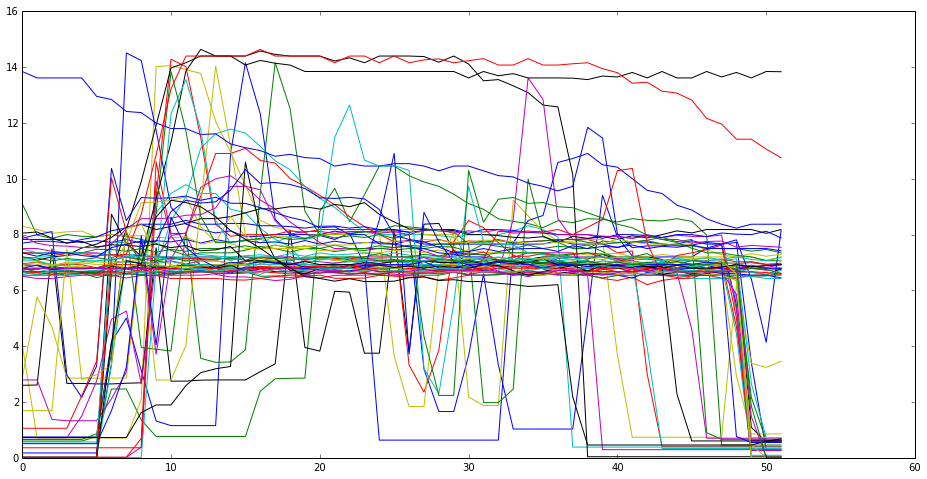

In [1088]:
print labels
for i in range (0,100):
    if best_values_df_concat['Type'].iloc[i] == 0:
        plt.plot(originalGraphDfDropNa.ix[pd.Timestamp(best_values_df_concat['startTimeStamp'].iloc[i]):pd.Timestamp(best_values_df_concat['stopTimeStamp'].iloc[i])])     

In [ ]:
# labels=pd.DataFrame(labels)
# concat= pd.concat([best_values_df_concat,labels],axis=1)
# concat.columns=['Manhattan','startTimeStamp','stopTimeStamp','Max', 'Mean', 'Median', 'normManhattan','normMax', 'normMean','normMedian', 'Type']

<h3>Adding height/mean/median to dataframe</h3>

<h4> Clusters and labels for height </h4>

In [ ]:
df_result_height = pd.DataFrame(data=[best_values_df_concat['normManhattan'].as_matrix(),best_values_df_concat['normMedian'].as_matrix(),best_values_df_concat['normMean'].as_matrix()]).transpose()
result_height=df_result_height.as_matrix()

In [ ]:
ms = MeanShift()
ms.fit(result_height)
labels_height = ms.labels_
cluster_centers_height = ms.cluster_centers_
n_cluster_height = len(np.unique(labels_height))
colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']

In [ ]:
# labels_height=pd.DataFrame(labels_height)
# df=(labels-labels_height)
# # with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
# #     print df

In [ ]:
for i in range(len(result_height)):
    plt.plot(result_height[i][0], result_height[i][1], colors[labels_height[i]], markersize = 10)

plt.scatter(cluster_centers_height[:,0],cluster_centers_height[:,1], marker = "x", s = 150, linewidths = 5, zorder = 10)
print labels_height
plt.xlabel('score')
plt.ylabel('height')
plt.show()

In [ ]:
labels_height=pd.DataFrame(labels_height)
concat_height= pd.concat([bestValuesDfConcat,labels_height],axis=1)
concat_height.columns=['Manhattan','startTimeStamp','stopTimeStamp','Max', 'Mean', 'Median', 'normManhattan','normMax', 'normMean','normMedian', 'Type']

<h3> Printing different cluster labels </h3>

In [ ]:
for i in range (0,100):
    if concat_height['Type'].iloc[i] == 1:
        plt.plot(originalGraphDfDropNa.ix[pd.Timestamp(concat_height['startTimeStamp'].iloc[i]):pd.Timestamp(concat_height['stopTimeStamp'].iloc[i])])

<h4> Clusters and labels for median </h4>

<h4>Comparison with dataframe which looks nothing like the original dataframe</h4>

In [ ]:
charts.plot(originalGraph, stock=True, show='inline')

In [ ]:
dfCompareOriginal10=originalGraphDf.ix[pd.Timestamp('2015-11-14 09:00:00+00:00'):pd.Timestamp('2015-11-14 09:51:00+00:00')]

In [ ]:
dfCompareOriginal10.size

In [ ]:
print "Manhattan:", manhattanDistance2(dfCompareOriginal,dfCompareOriginal10)
npdfCompareOriginal=np.array(dfCompareOriginal)
npdfCompareOriginal10=np.array(dfCompareOriginal10)
print "Euclidean:", euclideanDistance(npdfCompareOriginal,npdfCompareOriginal10)

#### PAA values

In [ ]:
#use paa values

#### Other compare, original values

In [ ]:
#testing other compare method

# Method on PAA values

In [ ]:
originalGraphDf

In [ ]:
calculateWeightsNewGraph(dfRepeatedValues, dfCompare, 10, 11000)

# Testing Graph Method

In [ ]:
dfWithValues=calculateWeightsNew(dfRepeatedValues, dfCompare, 20, 11000)

In [ ]:
concatinate=pd.concat([dfListWithStoredValues,dfListWithStoredValuesPAA],axis=1)
concatinate.columns=['col1','col2']
charts.plot(concatinate, stock=True, show='inline')

In [ ]:
#Check if timestamp is within boundaries of a value already present in the list.
            #If it is, and if the value is lower than the value present, it will interchange the value.
            
            #One problem that may occur: it will replace the value that was present with a new Timestamp, a timestamp
            #which is later than the previous timestamp. If a new value comes in, and it is within the boundaries of this second
            #timestamp, but not within the boundaries of the first one replaced, it will still replace the second one
            #resulting in the third timestamp replacing the second one without the first one being present anymore while they
            #were actually two different stamps.
            
            #How to solve? Store the stopTimeStamp of the replaced value, and only if the value after being replaced, is lower than this stopTimeStamp,
            #Then the third timestamp can replace the second one, otherwise it will add it as a new entry and clear the stopTimeStamp

In [ ]:
 def savingBestValues(dfWithValues, arrayToCompare, amountOfSaves, amountOfValues):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    valuesList=[]

    #Create list with results of the methods
    resultList=[]
    dfResult=pd.DataFrame(resultList)

    compareToArray=np.array(arrayToCompare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    loopIndex=0 #Loops through the resultslist, as long as its size
    currentSaves=0 
    arrayWithValues=np.array(dfWithValues)
    startingTimeStamp=dfWithValues.index[0]#Todo with speed
    stopTimeStamp=dfWithValues.index[arrayToCompare.size-1]
    while i < arrayToCompare.size+j: #i is dependent on j, i updates as j updates.
        valuesList.append(([arrayWithValues[i][0]]))
        #print "Value now:", arrayWithValues[i]
        i=i+1
        valuesToArray=np.array(valuesList)
        #print "i:",i
        if(i==(arrayToCompare.size+j)) and(j<amountOfValues) and (i<=(dfWithValues.size-arrayToCompare.size)): #amountOfValuesToBeConsidered.
            #print "i:",i, "compare", arrayToCompare.size+j
            if(j==0) or (manhattanDistance2(compareToArray,valuesToArray)!=resultList[len(resultList)-1][0]):
                resultList.append([manhattanDistance2(compareToArray,valuesToArray), startingTimeStamp,stopTimeStamp]) #Create list with values
            j=j+1
            i=j
            startingTimeStamp=dfWithValues.index[j]
            stopTimeStamp=dfWithValues.index[arrayToCompare.size+j-1]
            valuesList=[]
    #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
    while loopIndex < len(resultList):
        if(currentSaves<amountOfSaves):
            #print "currentsaves", currentSaves, [value,timeStamp]
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            dfResult=dfResult.append(pd.DataFrame([[value, startTimeStamp,stopTimeStamp]], index=[currentSaves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            currentSaves=currentSaves+1
            #print "index:",loopIndex
        elif(resultList[loopIndex-1][0] < resultList[loopIndex-2][0]) and (resultList[loopIndex-1][0] < resultList[loopIndex][0]) and resultList[loopIndex-1][0] < dfResult.max()['Manhattan']:
            #If the value in the dataset is smaller than its 2 neighbours AND the value is smaller than the maximum value present in the dataframe at this moment.
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            dfResult.loc[dfResult['Manhattan'].idxmax()]=[value,startTimeStamp, stopTimeStamp]
        loopIndex=loopIndex+1
    dfResult=dfResult.sort_values(['startTimeStamp'])
    print(time.time()-start)
    return dfResult
                    

In [ ]:
 def calculateWeightsNew(dfWithValues, arrayToCompare, amountOfSaves, amountOfValues):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    valuesList=[]

    #Create list with results of the methods
    resultList=[]
    dfResult=pd.DataFrame(resultList)

    compareToArray=np.array(arrayToCompare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    loopIndex=0 #Loops through the resultslist, as long as its size
    currentSaves=0 
    arrayWithValues=np.array(dfWithValues)
    startingTimeStamp=dfWithValues.index[0]#Todo with speed
    stopTimeStamp=dfWithValues.index[arrayToCompare.size-1]
    while i < arrayToCompare.size+j: #i is dependent on j, i updates as j updates.
        valuesList.append(([arrayWithValues[i][0]]))
        #print "Value now:", arrayWithValues[i]
        i=i+1
        valuesToArray=np.array(valuesList)
        #print "i:",i
        if(i==(arrayToCompare.size+j)) and(j<amountOfValues) and (i<=(dfWithValues.size-arrayToCompare.size)): #amountOfValuesToBeConsidered.
            #print "i:",i, "compare", arrayToCompare.size+j
            if(j==0) or (manhattanDistance2(compareToArray,valuesToArray)!=resultList[len(resultList)-1][0]):
                resultList.append([manhattanDistance2(compareToArray,valuesToArray), startingTimeStamp,stopTimeStamp]) #Create list with values
            j=j+1
            i=j
            startingTimeStamp=dfWithValues.index[j]
            stopTimeStamp=dfWithValues.index[arrayToCompare.size+j-1]
            valuesList=[]
    #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
    while loopIndex < len(resultList):
        if(currentSaves<amountOfSaves):
            #print "currentsaves", currentSaves, [value,timeStamp]
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            dfResult=dfResult.append(pd.DataFrame([[value, startTimeStamp,stopTimeStamp]], index=[currentSaves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            currentSaves=currentSaves+1
            #print "index:",loopIndex
        elif(resultList[loopIndex-1][0] < resultList[loopIndex-2][0]) and (resultList[loopIndex-1][0] < resultList[loopIndex][0]) and resultList[loopIndex-1][0] < dfResult.max()['Manhattan']:
            #If the value in the dataset is smaller than its 2 neighbours AND the value is smaller than the maximum value present in the dataframe at this moment.
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            dfResult.loc[dfResult['Manhattan'].idxmax()]=[value,startTimeStamp, stopTimeStamp]
        loopIndex=loopIndex+1
    dfResult=dfResult.sort_values(['startTimeStamp'])
    print(time.time()-start)
    return dfResult
                    

In [ ]:
 def create_list_view(df_with_values, array_to_compare, amount_of_saves, amount_of_values):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    values_list=[]
    #Create list with results of the methods
    result_list=[]
    df_result=pd.DataFrame(result_list)
    compare_to_array=np.array(array_to_compare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    loop_index=0 #Loops through the resultslist, as long as its size
    current_saves=0 #Current amount of variables saved
    array_with_values=np.array(df_with_values)
    starting_time_stamp=df_with_values.index[0]#Todo with speed
    stop_time_stamp=df_with_values.index[array_to_compare.size-1]
    
    #Threshold
    threshold_value=array_to_compare.size/10
    #LOOPING THROUGH LIST
    while i < array_to_compare.size+j: #i is dependent on j, i updates as j updates.
        values_list.append(([array_with_values[i][0]]))
        i=i+1
        if(i==(array_to_compare.size+j)) and(j<amount_of_values) and (i<=(df_with_values.size-array_to_compare.size)): #amountOfValuesToBeConsidered.
            #j = the minute at this moment. i = starting from the current minute, adding the size of the array to compare.
            #Stops running when the limit of values to be considered is reached, being the size the original array.
            values_to_array=np.array(values_list)
            if(j==0) or (manhattanDistance2(compare_to_array,values_to_array)!=result_list[len(result_list)-1][0]):
                #Create list with values. Save them in "resultList". Euclidean score, startTimestamp, stopTimestamp
                result_list.append([manhattanDistance2(compare_to_array,values_to_array), starting_time_stamp,stop_time_stamp]) 
            j=j+1
            starting_time_stamp=df_with_values.index[j] #startingTimeStamp: current minute considered
            stop_time_stamp=df_with_values.index[i] #stopTimeStamp: current minute considered + size of array to compare.
            i=j
            values_list=[]
    
    print "finished looping: ", time.time()-start
    print result_list
    #SAVING ONLY RELEVANT VALUES       
    #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
    while loop_index < len(result_list):
        if(loop_index==0):
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index][0], result_list[loop_index][1], result_list[loop_index][2]]
            df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            current_saves=current_saves+1
        if(result_list[loop_index-1][0] < result_list[loop_index-2][0]) and (result_list[loop_index-1][0] < result_list[loop_index][0]) and result_list[loop_index-1][0] < df_result.max()['Manhattan']:
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index-1][0], result_list[loop_index-1][1], result_list[loop_index-1][2]]
            list_with_values=[]
            max_value=0
            i=0
            #!!!Timestamps are important. If timestamp is within the range of another timestamp already present,
            #they will overwrite eachother instead of adding a new unique value
            while i < df_result.index.size:
                if(start_time_stamp >= df_result['startTimeStamp'][i]) and (start_time_stamp <= df_result['stopTimeStamp'][i]-pd.Timedelta(minutes=threshold_value)):
                    #INSIDE BOUNDARIES
                    if(df_result.loc[i][0] > max_value) and (df_result.loc[i][0]!=0): #Store the maximum value, of the range between start and stoptimestamp.
                        max_value=df_result.loc[i][0]
                        ts=df_result.loc[i][1]
                    elif(df_result.loc[i][0]==0): #PERFECT MATCH
                        max_value=1 #Not 0 because otherwise we assume it is outside of the boundaries
                i=i+1
            if(max_value==0): 
                #OUTSIDE BOUNDARIES
                    df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
                    current_saves=current_saves+1
                #INSIDE BOUNDARIES - 
            elif(value < max_value): #Check if the current value is smaller than the Maximum value encountered. Replace if it is.
                    df_result.loc[df_result['Manhattan']== max_value] = [value, start_time_stamp, stop_time_stamp]
        loop_index=loop_index+1
    df_result=df_result.sort_values(['Manhattan'])
    print "finished saving relevant values: ",time.time()-start
    return df_result
#     return charts.plot(listWithGraphs, stock=True, show='inline')
        

In [132]:
best_values_df_list

,Manhattan,startTimeStamp,stopTimeStamp
20,0.000000,2015-11-13 16:25:00+00:00,2015-11-13 17:16:00+00:00
25,51.040555,2015-11-14 06:04:00+00:00,2015-11-14 06:55:00+00:00
49,52.612096,2015-11-17 17:11:00+00:00,2015-11-17 18:02:00+00:00
26,55.597896,2015-11-14 14:13:00+00:00,2015-11-14 15:04:00+00:00
64,60.481144,2015-11-19 14:37:00+00:00,2015-11-19 15:28:00+00:00
13,64.541744,2015-11-12 09:57:00+00:00,2015-11-12 10:48:00+00:00
102,65.961733,2015-11-23 14:44:00+00:00,2015-11-23 15:35:00+00:00
34,70.112119,2015-11-15 16:07:00+00:00,2015-11-15 16:58:00+00:00
40,71.200876,2015-11-16 08:28:00+00:00,2015-11-16 09:19:00+00:00
69,71.506689,2015-11-20 05:28:00+00:00,2015-11-20 06:19:00+00:00


In [85]:
def calculate_threshold_value():
    best_values_df_list=create_list_view(originalGraphDfDropNa, dfCompareOriginal, 10, originalGraphDfDropNa.size)

,Manhattan,startTimeStamp,stopTimeStamp
32,0.000000,2015-11-13 16:25:00+00:00,2015-11-13 17:16:00+00:00
37,51.040555,2015-11-14 06:04:00+00:00,2015-11-14 06:55:00+00:00
64,52.612096,2015-11-17 17:11:00+00:00,2015-11-17 18:02:00+00:00
38,55.597896,2015-11-14 14:13:00+00:00,2015-11-14 15:04:00+00:00
82,60.481144,2015-11-19 14:37:00+00:00,2015-11-19 15:28:00+00:00
23,64.541744,2015-11-12 09:57:00+00:00,2015-11-12 10:48:00+00:00
122,65.961733,2015-11-23 14:44:00+00:00,2015-11-23 15:35:00+00:00
46,70.112119,2015-11-15 16:07:00+00:00,2015-11-15 16:58:00+00:00
53,71.200876,2015-11-16 08:28:00+00:00,2015-11-16 09:19:00+00:00
87,71.506689,2015-11-20 05:28:00+00:00,2015-11-20 06:19:00+00:00


<h3> Making methods more clear </h3>

In [111]:
array_with_values=np.array(originalGraphDfDropNa)

In [116]:
array_with_values[0]

array([ 7.91489362])

In [63]:
 def create_list_view(df_with_values, array_to_compare, amount_of_saves, amount_of_values):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    values_list=[]
    #Create list with results of the methods
    result_list=[]
    df_result=pd.DataFrame(result_list)
    compare_to_array=np.array(array_to_compare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    loop_index=0 #Loops through the resultslist, as long as its size
    current_saves=0 #Current amount of variables saved
    array_with_values=np.array(df_with_values)
    starting_time_stamp=df_with_values.index[0]#Todo with speed
    stop_time_stamp=df_with_values.index[array_to_compare.size-1]
    
    #Threshold
    threshold_value=array_to_compare.size/10
    #LOOPING THROUGH LIST
    while i < array_to_compare.size+j: #i is dependent on j, i updates as j updates.
        values_list.append(([array_with_values[i][0]]))
        i=i+1
        if(i==(array_to_compare.size+j)) and (i<(df_with_values.size)): #amountOfValuesToBeConsidered.
            #j = the minute at this moment. i = starting from the current minute, adding the size of the array to compare.
            #Stops running when the limit of values to be considered is reached, being the size the original array.
            values_to_array=np.array(values_list)
            if(j==0) or (manhattanDistance2(compare_to_array,values_to_array)!=result_list[len(result_list)-1][0]):
                #Create list with values. Save them in "resultList". Euclidean score, startTimestamp, stopTimestamp
                result_list.append([manhattanDistance2(compare_to_array,values_to_array), starting_time_stamp,stop_time_stamp]) 
            j=j+1
            starting_time_stamp=df_with_values.index[j] #startingTimeStamp: current minute considered
            stop_time_stamp=df_with_values.index[i] #stopTimeStamp: current minute considered + size of array to compare.
            i=j
            values_list=[]
    
    print "finished looping: ", time.time()-start
    print result_list
    #SAVING ONLY RELEVANT VALUES       
    #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
    while loop_index < len(result_list):
        if(loop_index==0):
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index][0], result_list[loop_index][1], result_list[loop_index][2]]
            df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            current_saves=current_saves+1
        if(result_list[loop_index-1][0] < result_list[loop_index-2][0]) and (result_list[loop_index-1][0] < result_list[loop_index][0]) and result_list[loop_index-1][0] < df_result.max()['Manhattan']:
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index-1][0], result_list[loop_index-1][1], result_list[loop_index-1][2]]
            list_with_values=[]
            max_value=0
            i=0
            #!!!Timestamps are important. If timestamp is within the range of another timestamp already present,
            #they will overwrite eachother instead of adding a new unique value
            while i < df_result.index.size:
                if(start_time_stamp >= df_result['startTimeStamp'][i]) and (start_time_stamp <= df_result['stopTimeStamp'][i]-pd.Timedelta(minutes=threshold_value)):
                    #INSIDE BOUNDARIES
                    if(df_result.loc[i][0] > max_value) and (df_result.loc[i][0]!=0): #Store the maximum value, of the range between start and stoptimestamp.
                        max_value=df_result.loc[i][0]
                        ts=df_result.loc[i][1]
                    elif(df_result.loc[i][0]==0): #PERFECT MATCH
                        max_value=1 #Not 0 because otherwise we assume it is outside of the boundaries
                i=i+1
            if(max_value==0): 
                #OUTSIDE BOUNDARIES
                    df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
                    current_saves=current_saves+1
                #INSIDE BOUNDARIES - 
            elif(value < max_value): #Check if the current value is smaller than the Maximum value encountered. Replace if it is.
                    df_result.loc[df_result['Manhattan']== max_value] = [value, start_time_stamp, stop_time_stamp]
        loop_index=loop_index+1
    df_result=df_result.sort_values(['Manhattan'])
    print "finished saving relevant values: ",time.time()-start
    return df_result
#     return charts.plot(listWithGraphs, stock=True, show='inline')
        

In [224]:
 def looping_through_list(df_with_values, array_to_compare):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    values_list=[]
    #Create list with results of the methods
    result_list=[]
    compare_to_array=np.array(array_to_compare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    array_with_values=np.array(df_with_values)
    #start and stop timestamp
    starting_time_stamp=df_with_values.index[0]
    stop_time_stamp=df_with_values.index[array_to_compare.size-1]
    
    #Threshold
    threshold_value=array_to_compare.size/10
    #LOOPING THROUGH LIST
    while i < array_to_compare.size+j: #i is dependent on j, i updates as j updates.
        #Save x amount of values where x is the size of the array to compare.
        values_list.append(([array_with_values[i][0]]))
        i=i+1
        if(i==(array_to_compare.size+j)) and (i<(df_with_values.size)):
            #j = the minute at this moment. i = starting from the current minute, adding the size of the array to compare.
            #Stops running when the limit of values to be considered is reached, being the size the original array.
            if(j==0) or (manhattanDistance2(compare_to_array,values_list)!=result_list[len(result_list)-1][0]):
                #Create list with unique values. Save them in "resultList". Euclidean score, startTimestamp, stopTimestamp
                result_list.append([manhattanDistance2(compare_to_array,values_list), starting_time_stamp,stop_time_stamp]) 
            j=j+1
            starting_time_stamp=df_with_values.index[j] #startingTimeStamp: current minute considered
            stop_time_stamp=df_with_values.index[i] #stopTimeStamp: current minute considered + size of array to compare.
            i=j
            values_list=[]
    print time.time()-start
    return result_list

In [225]:
 def local_minima_ts_correction(result_list):
    start=time.time()
    loop_index=0 #Loops throu"gh the resultslist, as long as its size
    current_saves=0 #Current amount of variables saved
    some_list=[]
    df_result=pd.DataFrame(some_list)
    ts=(list_view[0][2]-list_view[0][1])/10
    threshold_value=(ts / np.timedelta64(1, 'm')).astype(int)
    #SAVING ONLY RELEVANT VALUES       
    while loop_index < len(result_list):
        if(loop_index==0):
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index][0], result_list[loop_index][1], result_list[loop_index][2]]
            df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            current_saves=current_saves+1
        if(result_list[loop_index-1][0] < result_list[loop_index-2][0]) and (result_list[loop_index-1][0] < result_list[loop_index][0]) and result_list[loop_index-1][0] < df_result.max()['Manhattan']:
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index-1][0], result_list[loop_index-1][1], result_list[loop_index-1][2]]
            list_with_values=[]
            i=0
            max_value=0
            #!!!Timestamps are important. If timestamp is within the range of another timestamp already present,
            #they will overwrite eachother instead of adding a new unique value
            while i < df_result.index.size:
                if(start_time_stamp >= df_result['startTimeStamp'][i]) and (start_time_stamp <= df_result['stopTimeStamp'][i]-pd.Timedelta(minutes=threshold_value)):
                    #INSIDE BOUNDARIES
                    if(df_result.loc[i][0] > max_value) and (df_result.loc[i][0]!=0): #Store the maximum value, of the range between start and stoptimestamp.
                        max_value=df_result.loc[i][0]
                        ts=df_result.loc[i][1]
                    elif(df_result.loc[i][0]==0): #PERFECT MATCH
                        max_value=1 #Not 0 because otherwise we assume it is outside of the boundaries
                i=i+1
            if(max_value==0): 
                #OUTSIDE BOUNDARIES
                    df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
                    current_saves=current_saves+1
                #INSIDE BOUNDARIES - 
            elif(value < max_value): #Check if the current value is smaller than the Maximum value encountered. Replace if it is.
                    df_result.loc[df_result['Manhattan']== max_value] = [value, start_time_stamp, stop_time_stamp]
        loop_index=loop_index+1
    df_result=df_result.sort_values(['Manhattan'])
    print time.time()-start
    return df_result
        

In [226]:
def calculate_threshold_value(df_result, nr_of_best_values, factor):
    list_of_best_values=[]
    i = 0
    for i in range(0, nr_of_best_values):
        list_of_best_values.append(df_result.iloc[i])
    list_of_best_values=pd.DataFrame(list_of_best_values)
    mean=list_of_best_values.mean()
    threshold=mean*factor
    print threshold
    return df_result.loc[df_result['Manhattan']<=threshold[0]]
    

In [227]:
def create_graph_from(df):
    listWithGraphs=[]
    listWithGraphs=pd.DataFrame(listWithGraphs)
    for i in range (0, df.index.size):
        listWithGraphs=listWithGraphs.append(originalGraphDfDropNa.ix[pd.Timestamp(df['startTimeStamp'][i]):pd.Timestamp(df['stopTimeStamp'][i])])
    return charts.plot(listWithGraphs, stock=True, show='inline')

In [228]:
originalGraphDfDropNa

,212ce724e124fbde0fb649396375d099
2015-11-10 05:41:00+00:00,7.914894
2015-11-10 05:42:00+00:00,7.818440
2015-11-10 05:43:00+00:00,8.559350
2015-11-10 05:44:00+00:00,8.637550
2015-11-10 05:45:00+00:00,8.372093
2015-11-10 05:46:00+00:00,7.822674
2015-11-10 05:47:00+00:00,7.446429
2015-11-10 05:48:00+00:00,7.428571
2015-11-10 05:49:00+00:00,7.500000
2015-11-10 05:50:00+00:00,7.375000


In [229]:
list_view=looping_through_list(originalGraphDfDropNa, dfCompareOriginal)
df_result = local_minima_ts_correction(list_view)

35.2119710445
10.5551819801


In [173]:
list_view_sax=looping_through_list(dfRepeatedValues, dfCompare)
df_result_sax = local_minima_ts_correction(list_view_sax)

59.0247740746
7.12007880211


In [179]:
df_result_sax=df_result_sax.sort_values(['startTimeStamp'])

In [180]:
df_result=df_result.sort_values(['startTimeStamp'])

In [230]:
df_threshold=calculate_threshold_value(df_result, 20,1.5)

Manhattan    177.215488
dtype: float64


In [231]:
df_threshold

,Manhattan,startTimeStamp,stopTimeStamp
20,0.000000,2015-11-13 16:25:00+00:00,2015-11-13 17:16:00+00:00
25,51.040555,2015-11-14 06:04:00+00:00,2015-11-14 06:55:00+00:00
49,52.612096,2015-11-17 17:11:00+00:00,2015-11-17 18:02:00+00:00
26,55.597896,2015-11-14 14:13:00+00:00,2015-11-14 15:04:00+00:00
13,64.541744,2015-11-12 09:57:00+00:00,2015-11-12 10:48:00+00:00
34,70.112119,2015-11-15 16:07:00+00:00,2015-11-15 16:58:00+00:00
40,71.200876,2015-11-16 08:28:00+00:00,2015-11-16 09:19:00+00:00
32,93.254822,2015-11-15 06:49:00+00:00,2015-11-15 07:40:00+00:00
31,103.841869,2015-11-15 05:47:00+00:00,2015-11-15 06:38:00+00:00
15,108.904708,2015-11-12 19:14:00+00:00,2015-11-12 20:05:00+00:00


In [188]:
create_graph_from(df_threshold)

In [167]:
create_graph_from(thdf_reshdf)

In [70]:
# test=[]
# for i in range(0,10):
#     test.append(list_view[i][0])
#     test
# test=pd.DataFrame(test)
# test.mean()[0]

In [71]:
# test.mean()[0]

In [72]:
# list_of_values=[]
# i = 0
# for i in range(0, 10):
#     list_of_values.append(df_result.iloc[i])
# list_of_values=pd.DataFrame(list_of_values)
# mean=list_of_values.mean()


<h3> Widgets </h3>

In [92]:
from ipywidgets import widgets
from IPython.display import display

In [151]:
text = widgets.Text()
display(text)

def handle_submit(sender):
    print(sender.value)

text.on_submit(handle_submit)

In [94]:
button = widgets.Button(description="Click Me!")
display(button)

def on_button_clicked(b):
    print("Button Clicked.")
    
button.on_click(on_button_clicked)

<h3> Getting most recent value </h3>

In [95]:
list_of_val=calculate_threshold_value(df_result, 20,1.5)
list_of_val_sorted=list_of_val.sort_values(['startTimeStamp'])

Manhattan    121.656511
dtype: float64


In [96]:
ts=list_of_val_sorted.iloc[len(list_of_val)-1][1]
ts2=list_of_val_sorted.iloc[len(list_of_val)-2][1]

<h4> Dropdown menu </h4>

In [97]:
dropdown=widgets.Dropdown(
    options={'Coffee machine': 1, 'Washing machine': 2, 'Water Heater': 3, 'Heating System': 4, 'Dryer': 5, 'Oven': 6, 'Microwave': 7, 'Other':8},
    value=1,
    description='Apparaat:',
    )

<h4> Button </h4>

In [98]:
button = widgets.Button(description="Verify")

<h4>Text</h4>

In [99]:
from IPython.display import clear_output

In [100]:
text_other = widgets.Text()

In [101]:
# def handle_submit(sender):
#     if(sender.value == 8):
#         display(text_other) 
#     print sender.value

In [102]:
# def on_button_clicked(b):
#     handle_submit(dropdown)

In [103]:
# def submit_message():
#     print "Today you had an increase in electricity consumption at", ts, "just like" ,ts2, " would you like to label this device?"
#     display(dropdown)
#     display(button)
#     button.on_click(on_button_clicked)

In [115]:
stored_key_values=[]
def handle_submit_key(sender,val):
    if(val==0):
        stored_key_values.append(sender.value)
    print(sender.value)

# dropdown=widgets.Dropdown(
    options={'Coffee machine': 1, 'Washing machine': 2, 'Water Heater': 3, 'Heating System': 4, 'Dryer': 5, 'Oven': 6, 'Microwave': 7, 'Other':8},
    value=1,
    description='Apparaat:',
    )
textfield_machine=widgets.Text(
    description="Naam?")
textfield_frequency=widgets.Text(
    description="Hoeveel keer per week?")
def text_field(value):
    if(value==8):
        display(textfield_machine)
        display(textfield_frequency)
        textfield_machine.on_submit(handle_submit_key,1)
        textfield_frequency.on_submit(handle_submit_key,2)
    key_value=handle_submit_key(dropdown,0)
print("Today you had an increase in electricity consumption at", ts, "just like" ,ts2, " would you like to label this device?")
i=widgets.interactive(text_field, value=dropdown)
display(i)

In [177]:
text =widgets.BoundedIntText(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Text:',
    disabled=True
)

In [178]:
def sth():
    display(text)

In [207]:
stored_key_values=[]
def handle_submit_key(sender,val):
    if(val==0):
        stored_key_values.append(sender.value)
    print(sender.value)

In [220]:
text = widgets.Text()
display(text)

def handle_submit(sender):
    print(sender.value)


In [221]:
dropdown=widgets.Dropdown(
    options={'Coffee machine': 1, 'Washing machine': 2, 'Water Heater': 3, 'Heating System': 4, 'Dryer': 5, 'Oven': 6, 'Microwave': 7, 'Other':8},
    value=1,
    description='Apparaat:',
    )

In [222]:
def on_button_clicked(value):
    print value

In [224]:
text_new=widgets.Text()
button = widgets.Button(description="Verify")
display(button)
def text_field(value):
    if(value==8):
        display(text_new)
        text_new.on_submit(handle_submit)
    else:
        button.on_click(on_button_clicked(value))
print("Today at", ts,"you had an increase in electricity consumption, just like at ", ts2,"would you like to name this device?") #This just be above the dropdown menu and be stuck
i=widgets.interactive(text_field, value=dropdown)
display(i)
#button.on_click(on_button_clicked)

1


In [170]:
stored_key_values

[]